In [1]:
# Modifed code to work with our dataset
# Added data import and handling of our data
# Added data regularization
# updated for multiple inputs
# updated to split data evenly between different sources
# Transformed data using log10(Rex) and log10(Nux) before training- massively improved accuracy (from 26% to ~9% error)
# Updated so model prints metrics for each separate fluid as well
# Added ability to pick different loss function
# Added ability to pick different activation function
# Got rid of inlet turbulence feature
# Added physics based feature engineering
# Added hyperparameter tuning

### Import modules and data

In [2]:
# Import Modules
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy 
import optuna
from optuna.trial import TrialState
import joblib

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Explicitly select the first GPU
    torch.cuda.set_device(0)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU")

# Set seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Using GPU: NVIDIA GeForce RTX 3080 Ti


In [3]:
# Import data
df = pd.read_excel("https://raw.githubusercontent.com/adhicurry/ML_HeatTransfer_Fluids/main/FlatPlate_Models/Data_Combined_1.xlsx", engine='openpyxl')
# Replace Wall BC to numerical value
pd.set_option('future.no_silent_downcasting', True)
df['WallBC'] = df['WallBC'].replace({'UWT': 0, 'UHF': 1}).astype(float)

#df.columns
#df[['Rex', 'Nux', 'Pr']]    # Access multiple columns
#df['Figure'].unique()         # List unique ones
# Common commands
df.describe()


,WallBC,Pr,c,Rex,Nux
count,619.000000,619.000000,603.00000,6.190000e+02,619.000000
mean,0.807754,16.304750,2.42728,9.171941e+05,2053.819268
std,0.394384,47.544559,0.92966,9.569119e+05,2769.323298
min,0.000000,0.710000,1.40000,3.994911e+03,35.039791
25%,1.000000,0.710000,2.00000,2.122000e+05,323.409493
50%,1.000000,0.710000,2.50000,5.910482e+05,1163.035852
75%,1.000000,3.055000,2.50000,1.246501e+06,2670.941886
max,1.000000,257.000000,6.00000,4.710209e+06,19889.963767


In [4]:
# Actual data used for ANN development

# data_subset = df[df['Figure'].isin([2])]   # One figure only
# data_subset = df[df['Figure'].isin([2, 3, '4a', '4b', '4c'])]  ## Air only
#data_subset = df[df['Figure'].isin([2, 3, '4a', '4b', '4c', '6a','6b', 8 , '9a'])]  ## Air Water and Oil (except Fig 9b)


data_subset = df # Use all data

data_subset = data_subset.reset_index(drop=True)
data_subset.info()
#data_subset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Figure                   619 non-null    object 
 1   WallBC                   619 non-null    float64
 2   Pr                       619 non-null    float64
 3   c                        603 non-null    float64
 4   Rex                      619 non-null    float64
 5   Nux                      619 non-null    float64
 6   Dataset_Label            619 non-null    object 
 7   data_name_lienhard       619 non-null    object 
 8   Dataset author and year  619 non-null    object 
 9   Fluid                    619 non-null    object 
dtypes: float64(5), object(5)
memory usage: 48.5+ KB


## ANN Code

### Data split

In [5]:
# Define input features and output label
X = data_subset[['Rex', 'Pr', 'WallBC']].values
y = data_subset['Nux'].values
figures = data_subset['Figure'].astype(str).values

# Feature Engineering: Add physics-informed features
# Expand X_physics to include the new features (total 8 columns: 3 original + 5 physics-based)
Re_crit = 5e5

X_physics = np.zeros((X.shape[0], X.shape[1] + 5))
X_physics[:, :3] = X  # Copy original features
X_physics[:, 3] = X[:, 0] * (X[:, 1] ** (1/3))  # Rex*Pr^(1/3)
X_physics[:, 4] = X[:, 0] ** (4/5) * (X[:, 1] ** (1/3))  # Rex^(4/5)*Pr^(1/3) for turbulent
X_physics[:, 5] = (X[:, 0] >= Re_crit).astype(float) # 5) Laminar/Turbulent flag: Binary feature (0/1)
X_physics[:, 6] = np.tanh(X[:, 0]/Re_crit - 1) # 6) tanh(Re/Re_crit - 1): Smooth transition function
X_physics[:, 7] = np.log(X[:, 0]) # 7) log(Re): Helps capture turbulent behavior scaling (Probably not needed since i do this manually anyway)


#####################################################################################################################

# Pick specific features (MAKE SURE FIRST 3 (0,1,2) ARE ALWAYS INCLUDED (Re, Pr, WallBC) 
X = X_physics[:, [0, 1, 2]] 

# Add log transformation
X[:, 0] = np.log10(X[:, 0])  # Transform Rex (first column)
y = np.log10(y)              # Transform Nux


#####################################################################################################################

# Split Data into training, validation, and testing
# First split: separate test data from entire data
X_train_temp, X_test, y_train_temp, y_test, fig_train_temp, fig_test = train_test_split(
    X, y, figures,
    test_size=0.20,
    stratify=figures,
    shuffle=True,
    random_state=random_seed
)

# Second split: separate validation data from training data
X_train, X_val, y_train, y_val, fig_train, fig_val = train_test_split(
    X_train_temp, y_train_temp, fig_train_temp,
    test_size=0.15,
    stratify=fig_train_temp,
    shuffle=True,
    random_state=random_seed
)

# Initialize scalers
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit scalers on training data and transform all sets
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

# Reshape y values to 2D array for scaling
y_train_2d = y_train.reshape(-1, 1)
y_val_2d = y_val.reshape(-1, 1)
y_test_2d = y_test.reshape(-1, 1)
y_train_scaled = y_scaler.fit_transform(y_train_2d)
y_val_scaled = y_scaler.transform(y_val_2d)
y_test_scaled = y_scaler.transform(y_test_2d)

# Convert to PyTorch Tensors and move to device
X_train_tensor = torch.Tensor(X_train_scaled).float().to(device)
y_train_tensor = torch.Tensor(y_train_scaled).float().to(device)
X_val_tensor = torch.Tensor(X_val_scaled).float().to(device)
y_val_tensor = torch.Tensor(y_val_scaled).float().to(device)
X_test_tensor = torch.Tensor(X_test_scaled).float().to(device)
y_test_tensor = torch.Tensor(y_test_scaled).float().to(device)

# Save scalers for later use (important for making predictions on new data)
joblib.dump(X_scaler, 'X_scaler.save')
joblib.dump(y_scaler, 'y_scaler.save')

['y_scaler.save']

### Define Neural Network

In [6]:
# Define Neural Network Architecture
class NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.1, activation_fn='relu'):
        super(NN, self).__init__()
        
        # Define activation function based on parameter
        if activation_fn == 'relu':
            self.activation = nn.ReLU()
        elif activation_fn == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation_fn == 'tanh':
            self.activation = nn.Tanh()
        elif activation_fn == 'silu':
            self.activation = nn.SiLU()
        else:
            self.activation = nn.ReLU()  # Default
            
        # Create a flexible number of hidden layers
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[0]))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[i]))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, X):
        for i, (layer, batch_norm) in enumerate(zip(self.layers, self.batch_norms)):
            X = layer(X)
            X = batch_norm(X)
            X = self.activation(X)
            X = self.dropout(X)
        
        X = self.output_layer(X)
        return X
    
    def save(self, path):
        """Save model parameters."""
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        """Load model parameters."""
        self.load_state_dict(torch.load(path))

def predict(model, X):
    """Make predictions using the trained model."""
    model.eval()
    with torch.no_grad():
        # Convert input to tensor if it's not already
        if not isinstance(X, torch.Tensor):
            X = torch.Tensor(X).float().to(device)
        predictions = model(X)
        return predictions.cpu().numpy().ravel()

# Function to calculate metrics
def calculate_metrics(predictions, actual_values):
    error_percentages = 100 * np.abs(predictions - actual_values) / actual_values
    metrics = {
        'MAE': np.mean(np.abs(predictions - actual_values)),
        'Average_Percentage_Error': np.mean(error_percentages),
        'Min_Error': np.min(error_percentages),
        'Max_Error': np.max(error_percentages),
        'Median_Error': np.median(error_percentages),
        'Percentile_68': np.percentile(error_percentages, 68),
        'Percentile_95': np.percentile(error_percentages, 95),
        'Percentile_99': np.percentile(error_percentages, 99),
        'Num_Samples': len(predictions)
    }
    return metrics

### Hyperparameter optimization

[I 2025-03-28 12:21:06,517] A new study created in memory with name: no-name-b44ddb90-c928-4425-8dee-9e91e075d2ff
[I 2025-03-28 12:21:08,040] Trial 0 finished with value: 0.2670934200286865 and parameters: {'n_layers': 5, 'hidden_size_0': 492, 'hidden_size_1': 185, 'hidden_size_2': 101, 'hidden_size_3': 229, 'hidden_size_4': 208, 'learning_rate': 4.8364360079627634e-05, 'weight_decay': 3.946994686047394e-05, 'dropout_rate': 0.2760890375354323, 'batch_size': 128, 'activation_fn': 'tanh', 'loss_type': 'mse'}. Best is trial 0 with value: 0.2670934200286865.
[I 2025-03-28 12:21:09,276] Trial 1 finished with value: 0.2104741483926773 and parameters: {'n_layers': 2, 'hidden_size_0': 280, 'hidden_size_1': 345, 'learning_rate': 2.133331384850456e-05, 'weight_decay': 0.00011211592990994583, 'dropout_rate': 0.31319424047350897, 'batch_size': 256, 'activation_fn': 'relu', 'loss_type': 'mae'}. Best is trial 1 with value: 0.2104741483926773.
[I 2025-03-28 12:21:10,427] Trial 2 finished with value: 

Number of finished trials:  1000
Best trial:
  Value:  0.045465316623449326
  Params: 
    n_layers: 3
    hidden_size_0: 151
    hidden_size_1: 372
    hidden_size_2: 305
    learning_rate: 0.0024553485148659324
    weight_decay: 6.444768770977012e-06
    dropout_rate: 0.011475924841146491
    batch_size: 64
    activation_fn: relu
    loss_type: mse


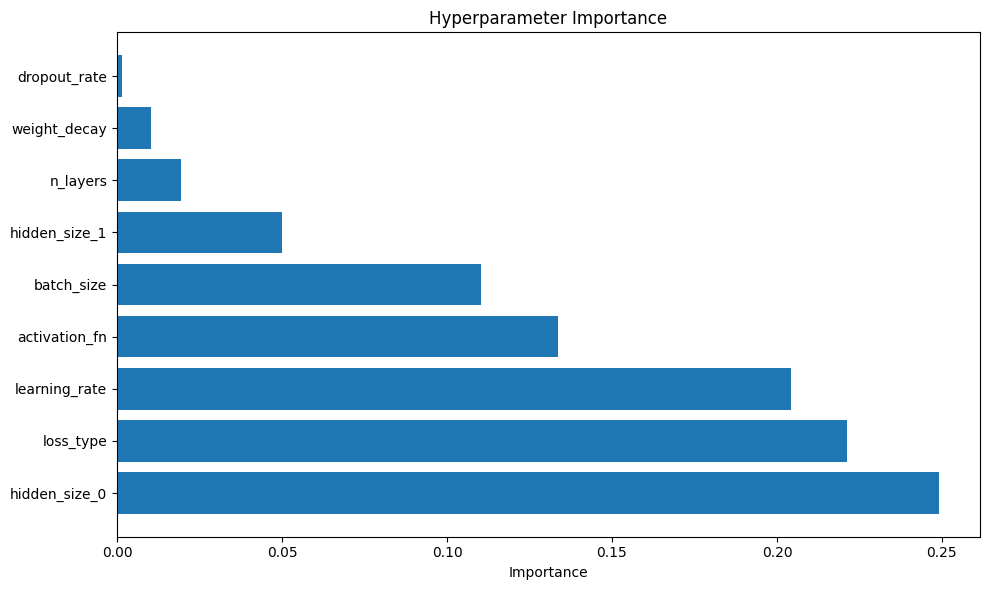

Training final model with best hyperparameters...
Epoch [10/5000], Train Loss: 0.147359, Val Loss: 0.103554
Epoch [20/5000], Train Loss: 0.120386, Val Loss: 0.070679
Epoch [30/5000], Train Loss: 0.105260, Val Loss: 0.125805
Epoch [40/5000], Train Loss: 0.082149, Val Loss: 0.058605
Epoch [50/5000], Train Loss: 0.082994, Val Loss: 0.059494
Epoch [60/5000], Train Loss: 0.087757, Val Loss: 0.154501
Epoch [70/5000], Train Loss: 0.074270, Val Loss: 0.066702
Epoch [80/5000], Train Loss: 0.076492, Val Loss: 0.066211
Epoch [90/5000], Train Loss: 0.062790, Val Loss: 0.071800
Epoch [100/5000], Train Loss: 0.072883, Val Loss: 0.056985
Epoch [110/5000], Train Loss: 0.073111, Val Loss: 0.055133
Epoch [120/5000], Train Loss: 0.077978, Val Loss: 0.065450
Epoch [130/5000], Train Loss: 0.087131, Val Loss: 0.054094
Epoch [140/5000], Train Loss: 0.076358, Val Loss: 0.072164
Epoch [150/5000], Train Loss: 0.065116, Val Loss: 0.060935
Epoch [160/5000], Train Loss: 0.063046, Val Loss: 0.061065
Epoch [170/5000

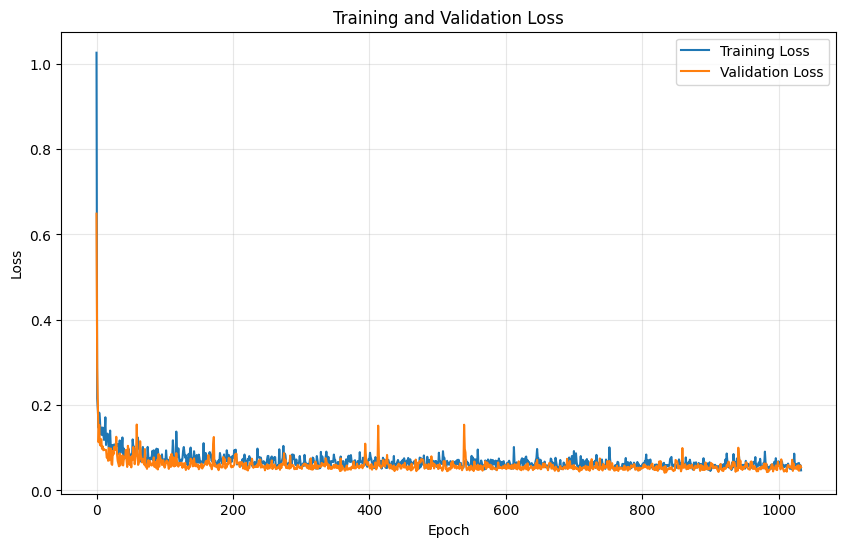

In [7]:
# Hyperparameter optimization objective function
def objective(trial):
    # Define hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 2, 5)
    hidden_sizes = []
    for i in range(n_layers):
        hidden_sizes.append(trial.suggest_int(f'hidden_size_{i}', 32, 512))
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    activation_fn = trial.suggest_categorical('activation_fn', ['relu', 'tanh']) # Can add others like "silu" and "leaky_relu"
    
    # Select loss function
    loss_type = trial.suggest_categorical('loss_type', ['mae', 'mse']) # Cann add huber
    if loss_type == 'mae':
        criterion = nn.L1Loss()
    elif loss_type == 'mse':
        criterion = nn.MSELoss()
    else:  # huber
        beta = trial.suggest_float('huber_beta', 0.1, 1.0)
        criterion = nn.SmoothL1Loss(beta=beta)
    
    # Initialize model with these hyperparameters
    model = NN(
        input_size=X_train.shape[1],
        hidden_sizes=hidden_sizes,
        output_size=1,
        dropout_rate=dropout_rate,
        activation_fn=activation_fn
    ).to(device)
    
    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
    
    # Early stopping parameters
    patience = 50
    patience_counter = 0
    best_val_loss = float('inf')
    
    # Training loop
    max_epochs = 2000 # Limit for hyperparameter tuning
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_batches = 0
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_batches += 1
            val_loss = val_loss / val_batches
            
            # Check for improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Early stopping
            if patience_counter >= patience:
                break
        
        # Report intermediate values to Optuna
        trial.report(val_loss, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return best_val_loss

# Run hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, timeout=86400)  # 1000 trials or 24 hours

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Visualize hyperparameter importance
try:
    importances = optuna.importance.get_param_importances(study)
    plt.figure(figsize=(10, 6))
    importance_values = list(importances.values())
    importance_names = list(importances.keys())
    plt.barh(importance_names, importance_values)
    plt.xlabel('Importance')
    plt.title('Hyperparameter Importance')
    plt.tight_layout()
    plt.show()
except:
    print("Could not compute hyperparameter importance.")

# Train the final model with the best hyperparameters
print("Training final model with best hyperparameters...")

# Extract best parameters
best_params = trial.params
n_layers = best_params['n_layers']
hidden_sizes = [best_params[f'hidden_size_{i}'] for i in range(n_layers)]
dropout_rate = best_params['dropout_rate']
activation_fn = best_params['activation_fn']
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
batch_size = best_params['batch_size']
loss_type = best_params['loss_type']

# Initialize the final model
final_model = NN(
    input_size=X_train.shape[1],
    hidden_sizes=hidden_sizes,
    output_size=1,
    dropout_rate=dropout_rate,
    activation_fn=activation_fn
).to(device)

# Initialize optimizer
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize loss function
if loss_type == 'mae':
    criterion = nn.L1Loss()
elif loss_type == 'mse':
    criterion = nn.MSELoss()
else:  # huber
    criterion = nn.SmoothL1Loss(beta=best_params.get('huber_beta', 0.5))

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

# Training variables
train_losses = []
val_losses = []
max_epochs = 5000
patience = 200
patience_counter = 0
best_val_loss = float('inf')
best_model = None

for epoch in range(max_epochs):
    # Training phase
    final_model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    final_model.eval()
    with torch.no_grad():
        val_loss = 0
        val_batches = 0
        for inputs, labels in val_loader:
            outputs = final_model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_batches += 1
        val_loss = val_loss / val_batches
        val_losses.append(val_loss)
        
        # Save the model if it has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(final_model)
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{max_epochs}], '
              f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print(f'Best validation loss: {best_val_loss:.6f}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save best model
best_model.save('best_NN_Model.pth')
final_model = best_model

### Evaluate Model

Category                 Overall     air     oil   water
Metric                                                  
Average_Percentage_Error   17.31   19.77    8.05   11.68
MAE                       273.60  223.34  340.80  502.78
Max_Error                 106.72  106.72   18.10   27.89
Median_Error               12.92   13.88    7.36   12.24
Min_Error                   0.70    1.25    0.70    1.77
Percentile_68              17.29   18.88   11.56   13.52
Percentile_95              47.72   55.39   17.64   22.27
Percentile_99              88.98   90.51   18.01   26.77


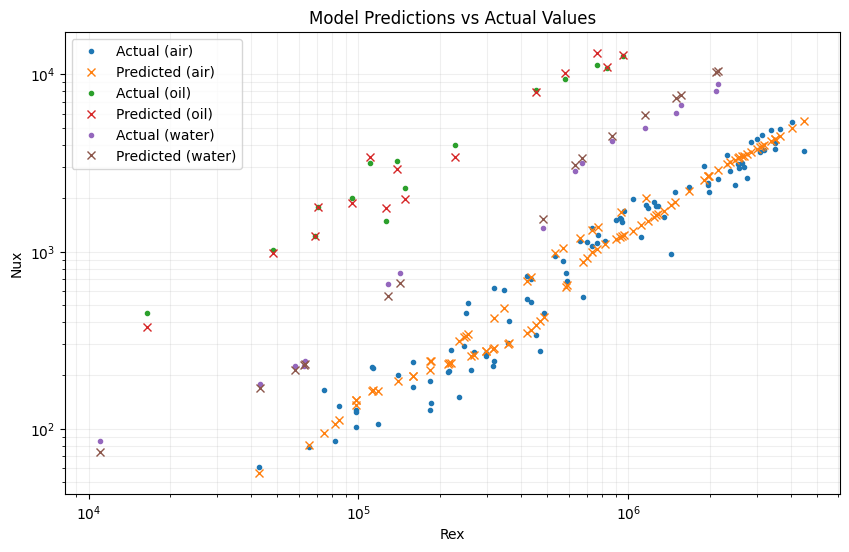

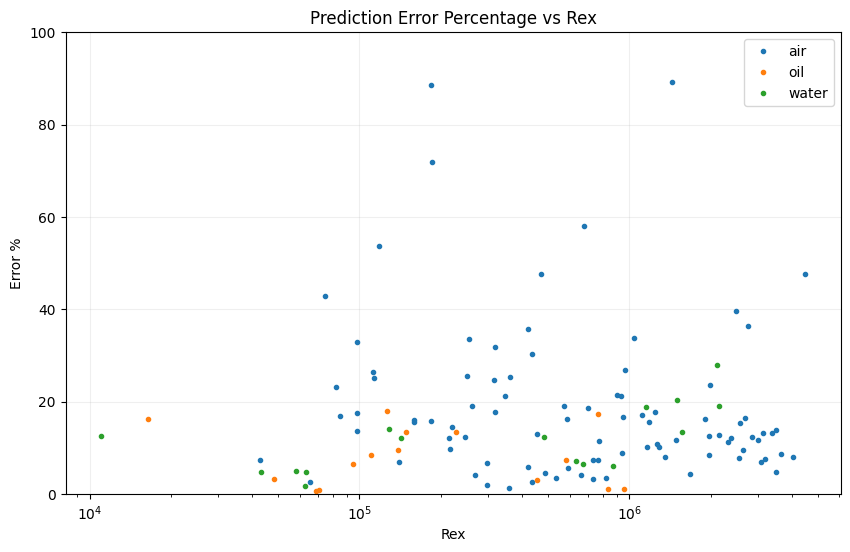

In [8]:
# Evaluation section
with torch.no_grad():
    final_model.eval()
    predictions = final_model(X_test_tensor)
    
    # First inverse transform the scaled predictions and actual values
    predictions_scaled = predictions.cpu().numpy()
    y_test_scaled = y_test_tensor.cpu().numpy()
    
    predictions_log = y_scaler.inverse_transform(predictions_scaled)
    y_test_log = y_scaler.inverse_transform(y_test_scaled)
    
    # Then inverse the log transformation
    predictions_original = 10**predictions_log
    y_test_original = 10**y_test_log
    
    # Get original Rex values
    X_test_scaled_np = X_test_tensor.cpu().numpy()
    X_test_log = X_scaler.inverse_transform(X_test_scaled_np)
    actual_Rex = 10**X_test_log[:, 0]
    
    # Get fluid types using the actual Rex values to match back to original data
    test_fluids = []
    for rex in actual_Rex:
        # Find the closest Rex in the original dataset
        idx = np.abs(data_subset['Rex'].values - rex).argmin()
        test_fluids.append(data_subset['Fluid'].iloc[idx])
    fluid_types = np.array(test_fluids)
    
    # Calculate overall metrics
    overall_metrics = calculate_metrics(predictions_original, y_test_original)
    
    # Calculate metrics by fluid type
    fluid_results = {}
    for fluid in np.unique(fluid_types):
        mask = fluid_types == fluid
        fluid_results[fluid] = calculate_metrics(
            predictions_original[mask], 
            y_test_original[mask]
        )
 
    # Create the DataFrame
    overall_data = [
        ["Overall", metric_name, value]
        for metric_name, value in overall_metrics.items()
        if metric_name != "Num_Samples"
    ]
    fluid_data = [
        [fluid, metric_name, value]
        for fluid, metrics in fluid_results.items()
        for metric_name, value in metrics.items()
        if metric_name != "Num_Samples"
    ]
    combined_data = overall_data + fluid_data
    results_df = pd.DataFrame(combined_data, columns=["Category", "Metric", "Value"])
    
    # Format the output
    results_df["Value"] = results_df["Value"].apply(lambda x: f"{x:.2f}")  # Format values to 2 decimal places
    styled_df = results_df.pivot(index="Metric", columns="Category", values="Value")  # Pivot for cleaner display
    print(styled_df.fillna("").to_string())  # Replace NaN with empty strings for clarity

    # Plotting section - separate by fluid
    plt.figure(figsize=(10, 6))
    for fluid in np.unique(fluid_types):
        mask = fluid_types == fluid
        plt.loglog(actual_Rex[mask], y_test_original[mask], '.', label=f'Actual ({fluid})')
        plt.loglog(actual_Rex[mask], predictions_original[mask], 'x', label=f'Predicted ({fluid})')
    
    plt.title('Model Predictions vs Actual Values')
    plt.xlabel('Rex')
    plt.ylabel('Nux')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.show()

    # Error percentage plot - separate by fluid
    plt.figure(figsize=(10, 6))
    for fluid in np.unique(fluid_types):
        mask = fluid_types == fluid
        error_percentage = 100 * np.abs(predictions_original[mask] - y_test_original[mask]) / y_test_original[mask]
        plt.semilogx(actual_Rex[mask], error_percentage, '.', label=fluid)
    
    plt.title('Prediction Error Percentage vs Rex')
    plt.xlabel('Rex')
    plt.ylabel('Error %')
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.ylim(0, 100)  # Limit y-axis to see the distribution better
    plt.show()


Fully Turbulent Air Data Metrics (Rex > 10^6):
Number of data points: 35
Mean error: ±17.12%
Two standard deviations (95% confidence): ±31.39%
95th percentile error: 42.05%
99th percentile error: 74.99%
Percentage of data within ±15%: 65.7%

Comparison with Lienhard's correlation:
Your model: 95th percentile error ±42.05% vs. Lienhard: ±11%
Your model: 65.7% of data within ±15% vs. Lienhard: 99.4%


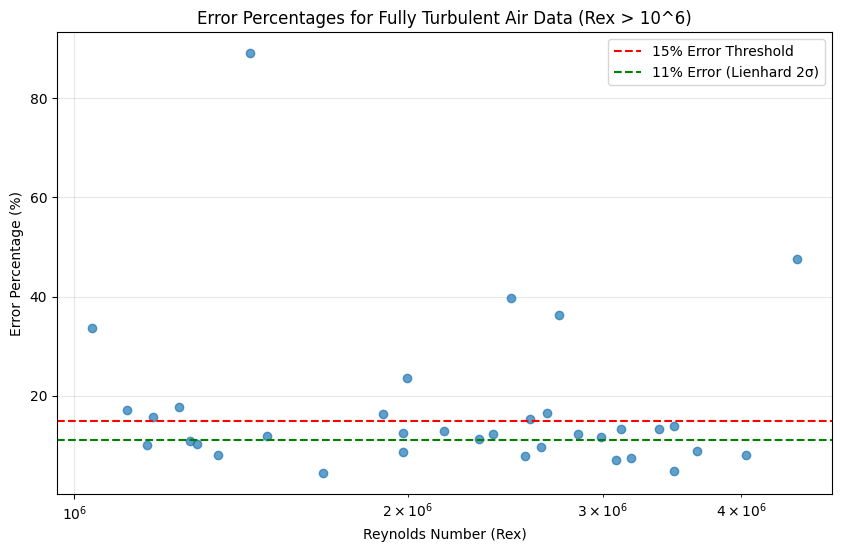

In [9]:
# Same error metric as Lienhard
# Extract metrics for fully turbulent air data only
with torch.no_grad():
    final_model.eval()
    predictions = final_model(X_test_tensor)
    
    # Get predictions in original scale
    predictions_scaled = predictions.cpu().numpy()
    y_test_scaled = y_test_tensor.cpu().numpy()
    
    predictions_log = y_scaler.inverse_transform(predictions_scaled)
    y_test_log = y_scaler.inverse_transform(y_test_scaled)
    
    predictions_original = 10**predictions_log
    y_test_original = 10**y_test_log
    
    # Get original Rex values and fluid types
    X_test_scaled_np = X_test_tensor.cpu().numpy()
    X_test_log = X_scaler.inverse_transform(X_test_scaled_np)
    actual_Rex = 10**X_test_log[:, 0]
    
    # Get fluid types
    test_fluids = []
    for rex in actual_Rex:
        idx = np.abs(data_subset['Rex'].values - rex).argmin()
        test_fluids.append(data_subset['Fluid'].iloc[idx])
    fluid_types = np.array(test_fluids)
    
    # Create mask for fully turbulent air data (Rex > 10^6)
    turbulent_air_mask = (fluid_types == 'air') & (actual_Rex > 1e6)
    
    # Calculate errors for this subset
    if np.any(turbulent_air_mask):
        turb_air_predictions = predictions_original[turbulent_air_mask]
        turb_air_actual = y_test_original[turbulent_air_mask]
        turb_air_rex = actual_Rex[turbulent_air_mask]
        
        # Calculate error percentages
        error_percentages = 100 * np.abs(turb_air_predictions - turb_air_actual) / turb_air_actual
        
        # Calculate statistics
        mean_error = np.mean(error_percentages)
        std_error = np.std(error_percentages)
        median_error = np.median(error_percentages)
        percentile_95 = np.percentile(error_percentages, 95)
        percentile_99 = np.percentile(error_percentages, 99)
        
        # Calculate percentage of data within ±15%
        within_15_percent = 100 * np.mean(error_percentages <= 15)
        
        # Print results in a format similar to Lienhard's reporting
        print("\nFully Turbulent Air Data Metrics (Rex > 10^6):")
        print(f"Number of data points: {len(turb_air_predictions)}")
        print(f"Mean error: ±{mean_error:.2f}%")
        print(f"Two standard deviations (95% confidence): ±{2*std_error:.2f}%")
        print(f"95th percentile error: {percentile_95:.2f}%")
        print(f"99th percentile error: {percentile_99:.2f}%")
        print(f"Percentage of data within ±15%: {within_15_percent:.1f}%")
        
        # Compare directly with Lienhard
        print("\nComparison with Lienhard's correlation:")
        print(f"Your model: 95th percentile error ±{percentile_95:.2f}% vs. Lienhard: ±11%")
        print(f"Your model: {within_15_percent:.1f}% of data within ±15% vs. Lienhard: 99.4%")
        
        # Create error vs Rex plot for fully turbulent air data
        plt.figure(figsize=(10, 6))
        plt.semilogx(turb_air_rex, error_percentages, 'o', alpha=0.7)
        plt.axhline(y=15, color='r', linestyle='--', label='15% Error Threshold')
        plt.axhline(y=11, color='g', linestyle='--', label='11% Error (Lienhard 2σ)')
        plt.title('Error Percentages for Fully Turbulent Air Data (Rex > 10^6)')
        plt.xlabel('Reynolds Number (Rex)')
        plt.ylabel('Error Percentage (%)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    else:
        print("No fully turbulent air data found in the test set.")

### Using ML Model with the best weights to recreate figures in lienhard paper

In [10]:
# First load the model with saved weights - modified for the new flexible architecture
# Get the best parameters from the optimization
n_layers = best_params['n_layers']
hidden_sizes = [best_params[f'hidden_size_{i}'] for i in range(n_layers)]
dropout_rate = best_params['dropout_rate']
activation_fn = best_params['activation_fn']

# Create a new model with the best hyperparameters
loaded_model = NN(
    input_size=X_train.shape[1],  # Updated input size including physics features
    hidden_sizes=hidden_sizes,    # Now uses a list of layer sizes
    output_size=1,
    dropout_rate=dropout_rate,
    activation_fn=activation_fn
).to(device)

# Load saved weights
loaded_model.load_state_dict(torch.load('best_NN_Model.pth', map_location=device))

# Rest of the code remains similar but needs to account for physics features
figures_to_plot = data_subset['Figure'].unique()
for fig in figures_to_plot:
    # Get data for this figure
    fig_data = data_subset[data_subset['Figure'] == fig]
    
    # Prepare input features - need to build physics features
    X_fig = fig_data[['Rex', 'Pr', 'WallBC']].values
    
    # Add physics-informed features (same as in training)
    X_fig_physics = np.zeros((X_fig.shape[0], X_fig.shape[1] + 2))
    X_fig_physics[:, :3] = X_fig  # Copy original features
    X_fig_physics[:, 3] = X_fig[:, 0] * (X_fig[:, 1] ** (1/3))  # Rex*Pr^(1/3)
    X_fig_physics[:, 4] = X_fig[:, 0] ** (4/5) * (X_fig[:, 1] ** (1/3))  # Rex^(4/5)*Pr^(1/3)
    
    X_fig = X_fig_physics
    
    # Apply log transformation to Rex
    X_fig[:, 0] = np.log10(X_fig[:, 0])
    
    # Scale the input
    X_fig_scaled = X_scaler.transform(X_fig)
    
    # Convert to tensor
    X_fig_tensor = torch.Tensor(X_fig_scaled).float().to(device)
    
    # Make predictions
    with torch.no_grad():
        loaded_model.eval()
        predictions = loaded_model(X_fig_tensor)
        
        # Transform predictions back to original scale
        predictions_scaled = predictions.cpu().numpy()
        predictions_log = y_scaler.inverse_transform(predictions_scaled)
        predictions_original = 10**predictions_log
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Create a color map to ensure consistent colors
    color_map = plt.colormaps['tab10']
    # Get unique datasets for this figure
    datasets = fig_data['data_name_lienhard'].unique()
    
    for i, dataset in enumerate(datasets):
        # Get data for this dataset
        mask = fig_data['data_name_lienhard'] == dataset
        
        # Choose a consistent color for this dataset
        dataset_color = color_map(i % color_map.N)
        
        # Plot original data
        plt.loglog(fig_data[mask]['Rex'], 
                  fig_data[mask]['Nux'], 
                  'o', 
                  color=dataset_color, 
                  label=f'{dataset} (Data)', 
                  markersize=4)
        
        # Plot model predictions
        sort_idx = np.argsort(fig_data[mask]['Rex'].values)
        rex_sorted = fig_data[mask]['Rex'].values[sort_idx]
        pred_sorted = predictions_original[mask][sort_idx]
        plt.loglog(rex_sorted, 
                  pred_sorted, 
                  '-', 
                  color=dataset_color, 
                  label=f'{dataset} (Model)', 
                  alpha=0.7)
    
    plt.title(f'Figure {fig} from Lienhard Paper')
    plt.xlabel('Rex')
    plt.ylabel('Nux')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

C:\Users\Daksh\AppData\Local\Temp\ipykernel_28460\1884650246.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('best_NN_Model.pth'

ValueError: X has 5 features, but StandardScaler is expecting 3 features as input.